# Introduction  

In this notebook, we are going to fine-tune _LayoutLMv3_ on the CORD dataset. For more info : [Github CORD](https://github.com/clovaai/cord)  
  The goal for the model is to detect **TTC amount** appearing in scanned receipts.

To add CORD dataset : [CORD dataset](https://drive.google.com/drive/folders/1_r2rgPKBqqFmEFoNvz2lQGfIIfRALJ_W)  
*For train folder: I used receipt_00001 to receipt_00199*  
*For test folder: I used receipt_00200 to receipt_00230*  

In [1]:
# Check if GPU is available in PyTorch
import torch
import os

# Check for GPU
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("Why GPU is not available.")

GPU is available!
GPU Name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


# Analysis

In [2]:
import glob
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
# Define the directory path and use glob to get all png files
train_files = glob.glob('train/image/*.png')
print(f"Number of files in train_files: {len(train_files)}")

Number of files in train_files: 200


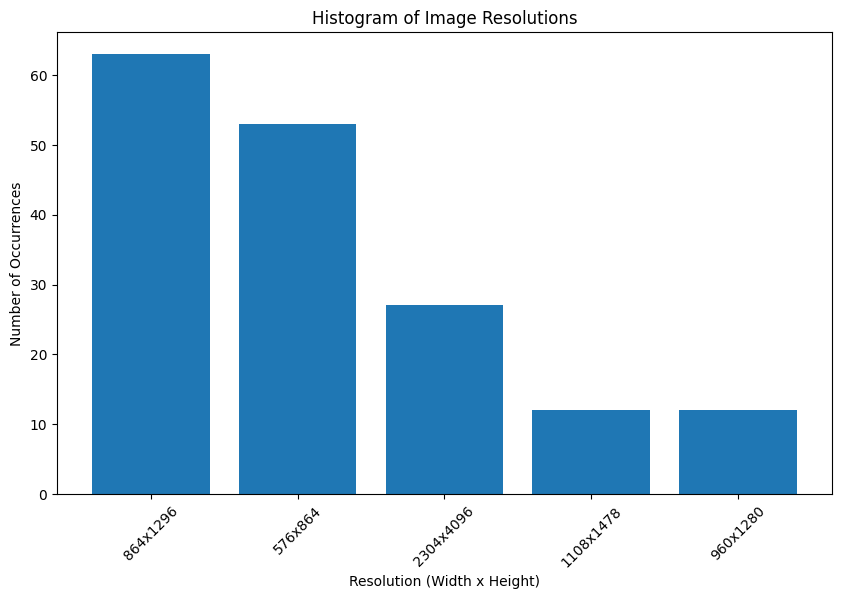

In [4]:
# Count occurrences of each resolution
resolution_counts = Counter(Image.open(file).size for file in train_files)

# Filter and sort resolutions by occurrences (highest to lowest)
filtered_counts = [(f"{width}x{height}", count) for (width, height), count in resolution_counts.items() if count > 10]
filtered_counts.sort(key=lambda x: x[1], reverse=True)

# Unzip filtered resolutions and counts for plotting
resolutions, counts = zip(*filtered_counts)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(resolutions, counts)
plt.xticks(rotation=45)
plt.ylabel('Number of Occurrences')
plt.xlabel('Resolution (Width x Height)')
plt.title('Histogram of Image Resolutions')
plt.show()



In [5]:
import json

receipt_image = Image.open('train/image/receipt_00002.png')

with open('train/json/receipt_00002.json') as json_file:
    receipt_json = json.load(json_file)


In [6]:
receipt_json.keys()

dict_keys(['dontcare', 'valid_line', 'meta', 'roi', 'repeating_symbol'])

In [7]:
receipt_json['valid_line'][0]

{'words': [{'quad': {'x2': 272,
    'y3': 489,
    'x3': 270,
    'y4': 489,
    'x1': 174,
    'y1': 461,
    'x4': 174,
    'y2': 459},
   'is_key': 0,
   'row_id': 539268,
   'text': 'HAKAU'},
  {'quad': {'x2': 379,
    'y3': 488,
    'x3': 380,
    'y4': 488,
    'x1': 280,
    'y1': 460,
    'x4': 278,
    'y2': 457},
   'is_key': 0,
   'row_id': 539268,
   'text': 'UDANG'}],
 'category': 'menu.nm',
 'group_id': 3}

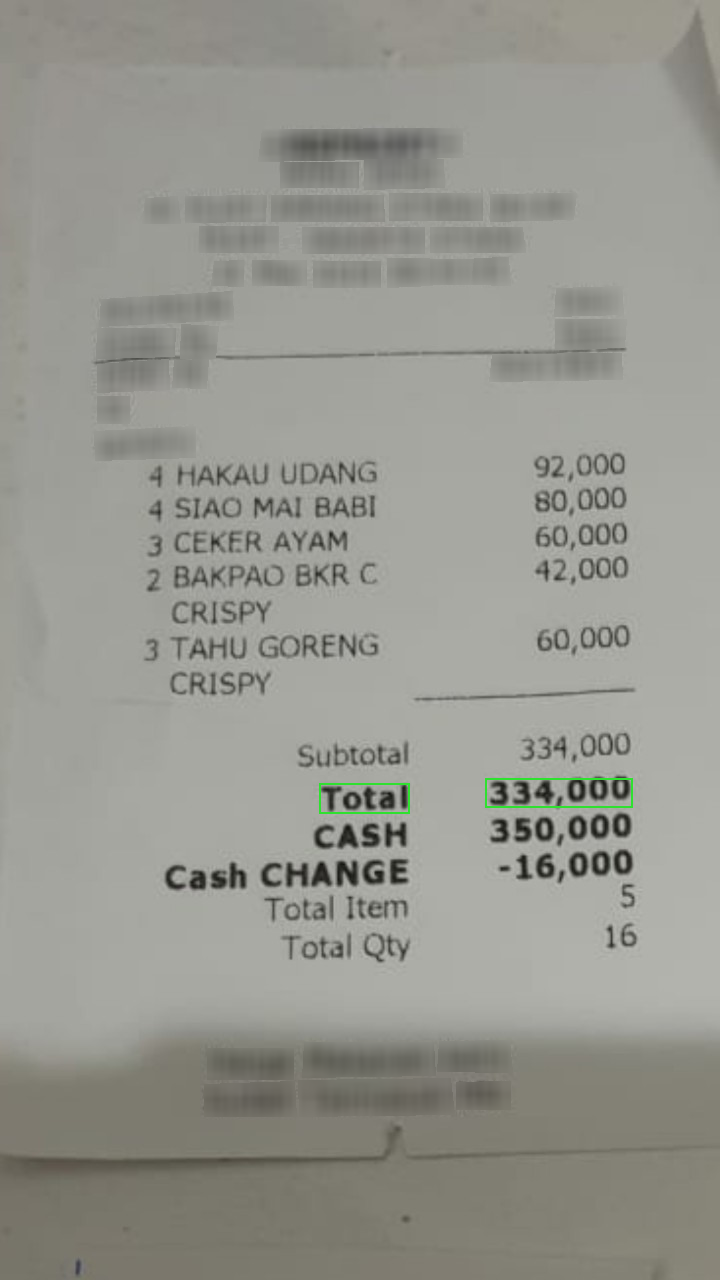

In [12]:
# Initialize drawing context and font
draw = ImageDraw.Draw(receipt_image, "RGBA")
font = ImageFont.load_default()

# Set the label and its associated color
label = "total.total_price"

# Draw annotations only for the specific label
for annotation in receipt_json['valid_line']:
    if annotation['category'] == label:
        words = annotation['words']
        for word in words:
            coordinates = word['quad']
            x1, y1 = coordinates['x1'], coordinates['y1']
            x3, y3 = coordinates['x3'], coordinates['y3']
            box = [x1, y1, x3, y3]
            draw.rectangle(box, outline="#2ee12f", width=2)

receipt_image

### Conclusion: 
1- To find TTC amount on receipt, we are looking for category **total.total_price**    
2- Most common size in my dataset is: **(864, 1296)**

# Generate annotations

In [13]:
from tqdm.notebook import tqdm
from pathlib import Path
import os

def normalize_bbox(bbox, width, height):
     return [
         int(1000 * (bbox[0] / width)),
         int(1000 * (bbox[1] / height)),
         int(1000 * (bbox[2] / width)),
         int(1000 * (bbox[3] / height)),
     ]

def generate_annotations(path: str):
  annotation_files = []
  image_files = []
  for js in tqdm(os.listdir(path)):
    image_files.append(Path(js).name.replace('.json', '.png'))
    with open(path + js) as f:
        annotation_files.append(json.load(f))

  words = []
  boxes = []
  labels = []
  images = []
  for js, im in tqdm(zip(annotation_files, image_files)):
      words_example = []
      boxes_example = []
      labels_example = []

      width, height = js['meta']['image_size']['width'], js['meta']['image_size']['height']
      
      for elem in js['valid_line']:
          for word in elem['words']:
              txt = word['text']

              # get bounding box in (upper left, lower right) format
              # Upper left is (x1, y3)
              # Lower right is (x3, y1)
              x1 = word['quad']['x1']
              y1 = word['quad']['y1']
              x3 = word['quad']['x3']
              y3 = word['quad']['y3']

              box = [x1, y1, x3, y3]
              box = normalize_bbox(box, width=width, height=height)

              # skip empty word
              if len(txt) < 1:
                continue

              words_example.append(txt)
              boxes_example.append(box)
              labels_example.append(elem['category'])
      words.append(words_example)
      boxes.append(boxes_example)
      labels.append(labels_example)
      images.append(im)

  return words, boxes, labels, images

In [14]:
train_path =  'train/json/'
test_path = 'test/json/'

words_train, boxes_train, labels_train, images_train = generate_annotations(train_path)
words_test, boxes_test, labels_test, images_test = generate_annotations(test_path)

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0it [00:00, ?it/s]

# Savings

In [15]:
import pickle
with open('./train.pkl', 'wb') as t:
    pickle.dump([words_train, labels_train, boxes_train, images_train], t)
with open('./test.pkl', 'wb') as t:
    pickle.dump([words_test, labels_test, boxes_test, images_test], t)

# Prepare the data

In [16]:
import pandas as pd

train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

In [17]:
def replace_labels(data, wanted_labels):
    return [[elem if elem in wanted_labels else 'Other' for elem in sublist] for sublist in data]

wanted_labels = ['total.total_price']  # Define the labels to keep (for now, We only want total.total_price)

# Replace labels in train and test datasets
train[1] = replace_labels(train[1], wanted_labels)
test[1] = replace_labels(test[1], wanted_labels)


In [18]:
all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)

Counter({'Other': 4877, 'total.total_price': 504})

In [19]:
labels = list(set(all_labels))
labels

['total.total_price', 'Other']

In [20]:
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)

{'total.total_price': 0, 'Other': 1}
{0: 'total.total_price', 1: 'Other'}


In [21]:
from os import listdir
from torch.utils.data import Dataset

class CORDDataset(Dataset):

    def __init__(self, annotations, image_dir, processor=None, max_length=256):
        self.words, self.labels, self.boxes, self.image_file_names = annotations
        self.image_dir = image_dir
        self.processor = processor

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        # first, take an image
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")

        # get word-level annotations
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        assert len(words) == len(boxes) == len(word_labels)

        word_labels = [label2id[label] for label in word_labels]
        # use processor to prepare everything
        encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels,
                                        padding="max_length", truncation=True,
                                        return_tensors="pt")

        # remove batch dimension
        for k,v in encoded_inputs.items():
          encoded_inputs[k] = v.squeeze()

        return encoded_inputs

In [22]:
from transformers import LayoutLMv3Processor, LayoutLMv3TokenizerFast, LayoutLMv3FeatureExtractor, LayoutLMv3ForTokenClassification

tokenizer = LayoutLMv3TokenizerFast.from_pretrained('microsoft/layoutlmv3-base')
processor = LayoutLMv3Processor(LayoutLMv3FeatureExtractor(apply_ocr=False), tokenizer)

C:\Users\abdel\Documents\GitHub\ReceiptsDetection_LayoutLMv3\env\Lib\site-packages\transformers\models\layoutlmv3\feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(


In [23]:
train_dataset = CORDDataset(annotations=train,
                            image_dir='train/image/',
                            processor=processor)
test_dataset = CORDDataset(annotations=test,
                            image_dir='test/image/',
                            processor=processor)

In [24]:
encoding = train_dataset[0]

In [25]:
for k,v in encoding.items():
  print(k, v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [26]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2)

# Train the model

In [27]:
model = LayoutLMv3ForTokenClassification.from_pretrained('microsoft/layoutlmv3-base', num_labels=len(labels))

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
from transformers import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 4

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
   print("Epoch:", epoch)
   for batch in tqdm(train_dataloader):
        # get the inputs;
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        pixel_values=pixel_values,
                        attention_mask=attention_mask,
                        labels=labels)
        loss = outputs.loss

        # print loss every 50 steps
        if global_step % 50 == 0:
          print(f"Loss after {global_step} steps: {loss.item()}")

        loss.backward()
        optimizer.step()
        global_step += 1

model.save_pretrained("model")

cuda
Epoch: 0


C:\Users\abdel\Documents\GitHub\ReceiptsDetection_LayoutLMv3\env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\abdel\Documents\GitHub\ReceiptsDetection_LayoutLMv3\env\Lib\site-packages\transformers\modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loss after 0 steps: 0.573165774345398
Loss after 50 steps: 0.07117795199155807
Epoch: 1


  0%|          | 0/100 [00:00<?, ?it/s]

Loss after 100 steps: 0.006542193237692118
Loss after 150 steps: 0.024572329595685005
Epoch: 2


  0%|          | 0/100 [00:00<?, ?it/s]

Loss after 200 steps: 0.005513130221515894
Loss after 250 steps: 0.01488927286118269
Epoch: 3


  0%|          | 0/100 [00:00<?, ?it/s]

Loss after 300 steps: 0.07385987788438797
Loss after 350 steps: 0.0020644182804971933


# Evaluate